<h1><center>Assignment 2 (FluNet dataset)</center></h1>
<center>Ben Lowery</center>

Sections:

0. [Prologue](#Prologue):  <br />
    0.1. Goals of the Dataset <br />
    0.2. Cleaning and preparing Dataset <br />
1. [Visualising the Dataset](#Section-1:-Visualising-the-Dataset): **Answering Q1**<br />
    1.1. Simple Time-series plot <br />
    1.2. Improved Visualisation with STL decomposition <br />
2. [Regression](#Section-2:-Regression-(ARIMA)): **Answering Q2** <br />
    2.1. Introduction to ARIMA <br />
    2.2. Preprocessing the dataset and finding variables <br />
    2.3. A naïve attempt to fit the model <br />
    2.4. Better fitting the model using STL decomposition <br />
    2.5. Suitability <br />
3. [Machine Learning](#Section-3:-Machine-Learning-(Neural-Network)): **Answering Q3**<br />
    3.1. Neural Networks for Time-series <br />
    3.2. Preparing Data <br />
    3.3. Training a MLP <br />
    3.4. Improving our Neural Network Model <br />
    3.5. Evaluation of model <br />
4. [Evaluation](#Section-4:-Evaluation): **Answering Q4** <br />
    4.1. Summary of Findings <br />
    4.2. Methodology Ranking <br />
    4.3. Limitations <br />
    4.4. Future Investigations
5. [References](#References)

# Prologue

## Goals of the Dataset

In this notebook, the aim is to find what flu cases will look like in the next yearly cycle in the United Kingdom, given a certain portion of the data. Holding a plethora of (often sporadically inputted) information between 1995 and 2019, the idea is to use the following methods:

* Graph visualisation
* A regression technique (ARIMA model)
* A machine learning technique (Neural Network)

And evaluate which one can forecast the best outcome. To evaluate performance, we require to compare the predictions the model makes to a 'test set' of cases. One way to do this would have been to source 2020 data for flu cases, this is likely a rather futile endeavour as given certain events in the world, the flu cases is likely to be an entire yearly cycle of anomalies! Instead, we can simply split our dataset into a training (to help inform us what we can predict) and a testing set (to see how good our predictions actually are). To achieve this, the last year and a half of data beginning 26/06/2018 will be assigned to a testing set, working out to around 10% of the dataset.

The most sensible way to format our dataset is in the form  of a time-series. I.e. we have some data at each time step, weekly in our situation, and we shall use to predict future time steps. We will also be using a univariate time series (one feature) and focusing on how just the historic case numbers can be used to predict future cases.

## Cleaning and Preparing Dataset

We can begin by importing the dataset, alongside some packages we know we will be using throughout.

In [2]:
%matplotlib inline

# Import packages and CSV
import pandas as pd
import numpy as np
import os
# This is to stop some keras/tensorflow warnings down the line
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import datetime

# !!!the statsmodels package is also called/used later on, which is not installed on the CoCalc server !!!

### Some preamble plot styling ###
# Set plot sizes
# Set plot style (ggplot, i think R has the best asthetics to plots)
plt.style.use('ggplot')
# Give a biggish plot style so we can clearly see whats going on
plt.rcParams["figure.figsize"] = (12,7)



# Read Raw csv data for flunet
data_raw_all=pd.read_csv('FluNetInteractiveReport.csv',parse_dates=True, dayfirst=True)

# Print last few rows
data_raw_all.tail()

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
1299,United Kingdom of Great Britain and Northern I...,European Region of WHO,Northern Europe,2019,48,25/11/2019,01/12/2019,NaN,2682.0,0.0,...,NaN,1198.0,1763.0,0.0,0.0,56.0,56.0,1819.0,NaN,No Report
1300,United Kingdom of Great Britain and Northern I...,European Region of WHO,Northern Europe,2019,49,02/12/2019,08/12/2019,NaN,2974.0,0.0,...,NaN,211.0,1020.0,0.0,0.0,15.0,15.0,1035.0,NaN,No Report
1301,United Kingdom of Great Britain and Northern I...,European Region of WHO,Northern Europe,2019,50,09/12/2019,15/12/2019,NaN,3293.0,0.0,...,NaN,307.0,1170.0,0.0,0.0,20.0,20.0,1190.0,NaN,No Report
1302,United Kingdom of Great Britain and Northern I...,European Region of WHO,Northern Europe,2019,51,16/12/2019,22/12/2019,NaN,3808.0,0.0,...,NaN,421.0,1371.0,0.0,0.0,25.0,25.0,1396.0,NaN,No Report
1303,United Kingdom of Great Britain and Northern I...,European Region of WHO,Northern Europe,2019,52,23/12/2019,29/12/2019,NaN,3095.0,0.0,...,NaN,469.0,1200.0,0.0,0.0,13.0,13.0,1213.0,NaN,No Report


Since we are only focused on the flu cases at any given week, we can just extract a cases column and a time stamp column. Note, there are a few different ways the dataset expresses the week each row is for, we will use the `SDATE` since that denotes the beginning of each week. Whilst `ALL_INF` provides us the total weekly cases.

In [3]:
# Select the columns we want
data_raw_all=data_raw_all[['SDATE', 'ALL_INF']]

We are not quite done however, as there are a few problems with the dataset. From external analysis, which is omitted to avoid unnecessary cluttering in the notebook, our problems are as follows:

* There is no data for flu cases until 27/12/2004
* There is still ~4% of missing data after this
* The week column needs to be the index so we can easily work with it in future sections

We can solve the first problem by removing all rows before the previously mentioned date. 

Then to replace the data, in time series a simple mean/mode substitution is not appropriate as it will just have the potential to cause unnatural fluctuations. Instead we can either replace with the previous time step (the persistence method) or use a mathematical tool called interpolation. Luckily, with Pandas, interpolation this is fairly easy. Built into the pandas DataFrame, is the [Interpolate](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html) function, which uses the mathematical technique of interpolation, to estimate values of these missing values (not to be confused with fitting a regression). There is obviously different ways to interpolate which depends on how the data is structured. For time series, we have the `method="time"` parameter we can add as an argument. The core of the interpolation method used by pandas for this is not immediately clear, however we know it'll utilise points close to the missing data to inform how best to replace the gaps; this leads to a fairly minimal impact on the underlying statistical qualities, and no strange anomalies that may be encountered if using mean/mode imputation.

The last problem can be fixed fairly easily in pandas and can all be seen in the following code block.

In [4]:
# Remove first 521 rows (i.e. when our data actually starts)
data_raw = data_raw_all.iloc[521:]

# Change index to dates (we need to do this before pandas lets us interpolate with time mechanic)
data=data_raw.copy()
data['SDATE']=pd.to_datetime(data['SDATE'],dayfirst=True)
data = data.set_index('SDATE')

# Interpolate missing data
data=data.interpolate(method='time')

Finally, given we are dealing in all methods with a test and training set, we can split our dataset as so. Referenced in the previous subsection, we start our testing set at 26/06/2018 which is 90% into the data.

In [5]:
# Split into train and test

# Get position of first 90% of dataset
perc=int(len(data)*(90/100))

# Split
data_train=data[:perc]
data_test=data[perc:]

Now we have a suitable dataset and can work on our first problem, visualisation.

# Section 1: Visualising the Dataset

## 1.1 Simple Time-Series Plot

With how our problem is framed, we can think of our key variables as the time steps we know, and our outcomes as the future time steps. Time-series provide a special subset of data science problems, and visualisation often takes the  simple form of a time-series plot (see below). In this case we shall just print the training set and see if we can see what our testing portion (or the next year and a half) could be. 

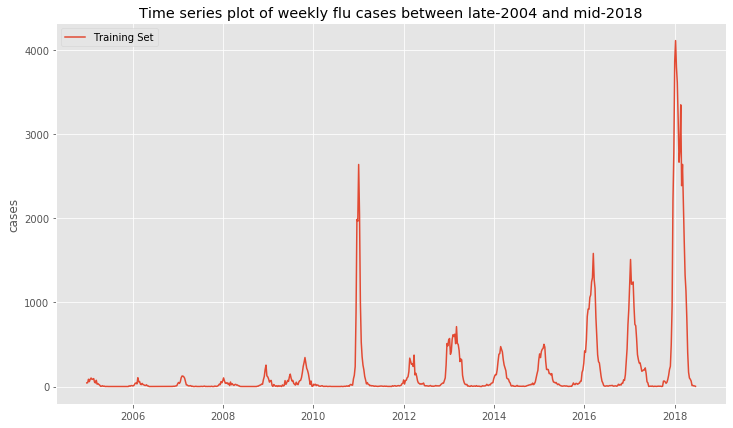

In [6]:
# Plot simple time series plot
plt.plot(data_train, label='Training Set')
plt.title('Time series plot of weekly flu cases between late-2004 and mid-2018')
plt.ylabel('cases')
plt.legend()
plt.show()

We can see a significant outlier, in the 2010/11 flu season and gradual increases up until our testing set begins. With just the training set and this simple graph, we could infer there is a strong seasonal trend, with regular peaks at spaced intervals. These peaks vary greatly in height so predicting what our next flu season could look like might be a tad difficult. A good guess would be another peak of similar proportion to the end of the 2018/19 season, then afterwards would be a bit of guesswork. 

Overall, this is kinda boring and even though by eye we can perhaps make an educated guess on how the testing set panned out, there is perhaps some underlying patterns we can extract better with a different type of visualisation, and incorporate some much more appropriate statistics that work better than simply eyeballing it. This leads us to STL decomposition.

## 1.2 Visualisation with STL Decomposition

STL decomposition, or Seasonal-Trend decomposition using LOESS as its also known, is a way of decomposing a time series into 3 components: trend, seasonality, and residual error [(Cleveland et al. 1990)](#References). Also useful in anomaly detection, we can primarily use this method to gather insight into datasets. Yet, it can also be utilised in further cleaning and then forecasting values alongside a conventional time series model. We will see this in action in further sections, but for now we can decompose our time series and see if we can better understand what our data is telling us from a visual perspective.

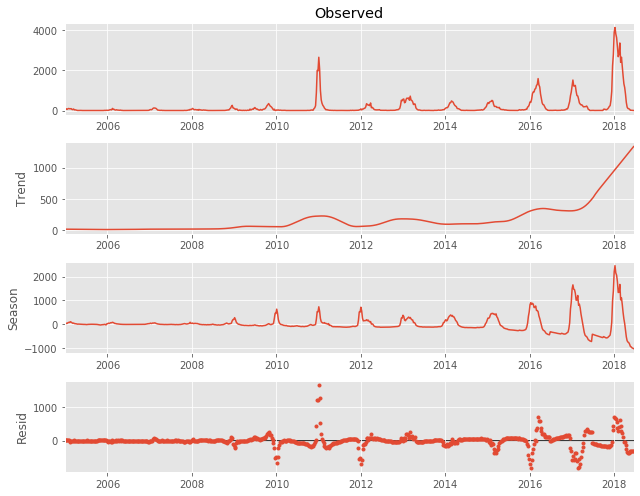

In [7]:
# STL decomposition
from statsmodels.tsa.seasonal import STL
# We can choose a seasonal method, here we stick with 7 
# (choosen after some external tinkering outside this notebook to see the AIC scores of different numbers)
stl = STL(data_train, seasonal=7)
stl_decom = stl.fit()

# Weird workaround to change figure size and marker size
with plt.rc_context():
    plt.rc("figure", figsize=(9,7))
    plt.rc('lines',markersize=3)
    fig = stl_decom.plot()

### Analysis

Decomposing the time series yields three graphs of information that makes up our dataset. From trend, we see we have a fairly flat trend until 2017, in which there becomes a strong positive trend. This perhaps indicates that future time periods will have a positive trend (so more cases than the year before). However, this analysis can be counteracted by looking at the seasonal period. You can see the seasons become more distinct, and larger, over time which highlights a link between trend and seasonality. As a result, we can perhaps adjust our conclusion and say the next year will have similar or slightly higher cases than the last period. 

The last factor to analyse is the residual component. This tells us where outliers lie, and case numbers that perhaps don't lie up to where we expect them to. The obvious culprit is the 2011 period, which we knew from the simple time series was a massive outlier, with the graph also reinforcing this is likely an anonomly as opposed to  having a seasonal cause.  Towards the end of the dataset, we also have some residual error, but we can attribute that to the sudden growth in peaks and the volatility in these peaks. Residual error won't change our interpretation of the data, but can make us aware of how the data becomes more unpredictable in later years.

Overall, from our data visualisation we can see a strong seasonal component in our data, and a heavy relation between trend and seasonality. With regards to how we model outcomes from this, our best analysis would be that we would have similar, if not larger, cases over the future seasonal periods; which is inferred from the strong positive trend and marginally offset by a large closing seasonality period.

STL decomposition is not foolproof, with many priors determined by both us and the default parameters, and may require tweaking and adaptations to get the best out of the data. Finally, to see how our predictions stack up we can add the testing data to the time series plot.

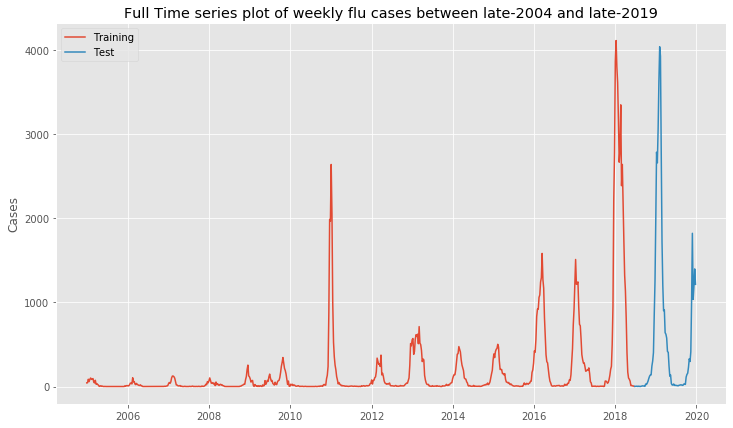

In [8]:
# Graph full time series
plt.title('Full Time series plot of weekly flu cases between late-2004 and late-2019')
plt.plot(data_train, label='Training')
plt.plot(data_test,label='Test')
plt.ylabel('Cases')
plt.legend()
plt.show()

We can see the first year in our testing dataset isn't too far off. Unfortunately this is not replicated in the beginning of the next period. But we did identify that this may be the case due to the residual error showing us there would be an air unpredictability.

# Section 2: Regression (ARIMA)

## 2.1 Introduction to ARIMA

There are a few methods we can use to predict and model a trends in a time series. Linear and polynomial regression models aren't particularly used - or are well suited for - time series models, as should be evident when looking at the time series plots. Instead we do have better suited, specialist methods that are employed.

We can crudely see time series equivalents of the "classical" regression techniques in Autoregression (AR) and Moving Average (MA). Given the data is fairly complex with clear trend, seasonality, and long periods of no cases; it would be fairly futile to just employ one of these two methods as they are both accustomed to simple, consistent data. Thus, we can combine these two methods to create what is called an `ARMA` model. We can take this even further by using an `ARIMA` model, with added Integration (I), to add a preprocessing aspect to our data. We can describe each part of the model as follows:

### Autoregressive (AR)
An Autoregressive model uses past data points (or lags) to predict future data points in a time series. To determine how far back we should go to predict the next point with pass through a parameter, $p$, known as the order. Mathematically we define this model as,

$$ y_{t}=\phi_{0}+\phi_{1}y_{t-1}+\phi_{2}y_{t-2}+...+\phi_{p}y_{t-p}+\epsilon_{t} $$

Where, $y_{t-i}$ are data lags, $\phi_{i}$ are coefficients (and a constant) our model needs to estimate. Whilst $\epsilon_{t} \sim \mathcal{N}(0,\sigma^2)$ and is some white noise/randomness added to the model.

### Moving Average (MA)
A moving average model uses errors in the time series forecast, as opposed to past values used in autoregressive models, to estimate future values. We denote the number of error lags by a parameter $q$. We can define the model as:

$$ y_{t}=\mu-\epsilon_{t}-\theta_{1}\epsilon_{t-1}-\theta_{2}\epsilon_{t-2}-...-\theta_{q}\epsilon_{t-q}$$

Where, $\mu$ denotes the mean, $\epsilon_{t-i}$ are white noise error terms distributed as in the AR model, and $\theta_{t-i}$ are coefficients to be found.

### Integrated (I)

By combining the two above parts, we attain an ARMA($p,q$) model expressed as:

$$ARMA(p,q): \ \ y_{t}=\mu+\sum_{i=1}^{p}\phi_{i}y_{t-i}-\sum_{j=1}^{q}\theta_{j}\epsilon_{t-q}$$

However, to get the best out of an ARMA model, we require something called stationarity. Meaning our stochastic process generating the time series has to have the same statistical properties at all times. Trend, Seasonality and other factors contribute to a time series losing this stationarity and from STL decomposition, we will clearly not have stationarity. To solve this, we can find the difference of the time series to its shifted self at a certain time lag, hopefully availing our model into providing the best results by removing the trend. The amount we shift the data to achieve stationarity is denoted $d$ and wraps up our theory to finally give us the ARIMA($p,d,q$) model. We apply the already defined above ARMA model but use the $d^{th}$ derivative time series values. 

**Note**, all of this is not to say that ARIMA is a simple model and is actually a rather complicated affair; especially when estimating the coefficients (This will be left to the python packages to optimise, in which they use maximum likelihood estimation). However, since it cobbles together well known, classic statistical techniques derived  in the 1970s [(Box et al. 2015)](#References), it likely fits the bill as **not** a machine learning technique, and a classical regression like model.

## 2.2. Preprocessing the dataset and finding variables

As alluded at in the introduction to this section, we have a fairly complex dataset, which violates a lot of requirements for an ARIMA model to fit well. We can try fix this firstly by looking at the $d$ parameter, and calculating the difference to a previous time lag, to try get some stationarity in our dataset. We can do this a few times and see if any gives us a consistent looking set of data.

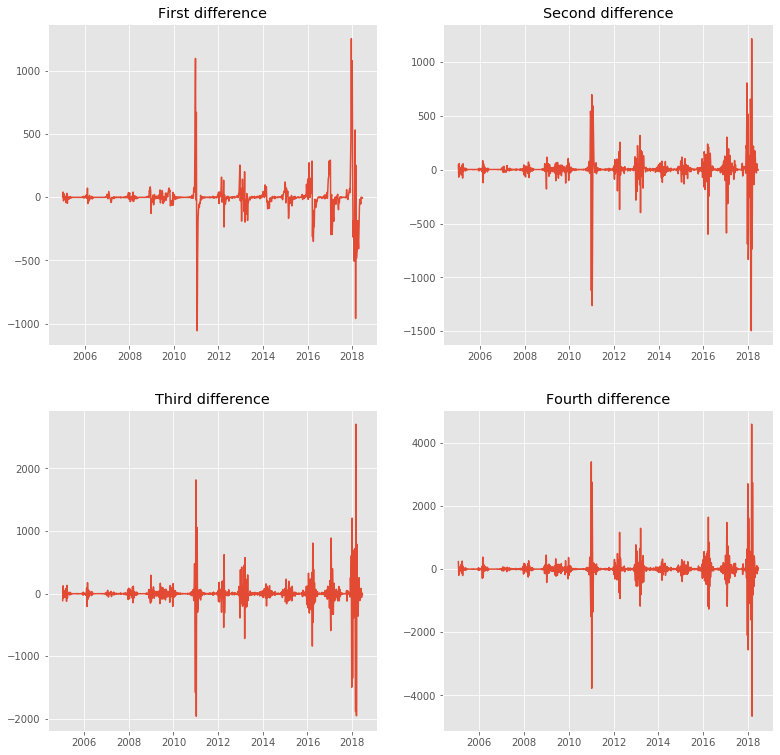

In [9]:
# Create copies of the test and train so we dont accidently change anything in the origianl data
reg_train=data_train.copy()
reg_test=data_test.copy()

# Take difference of dataset and plot
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(13,13))
ax[0,0].plot(reg_train.diff().dropna())
ax[0,0].set_title('First difference')
ax[0,1].plot(reg_train.diff().diff().dropna())
ax[0,1].set_title('Second difference')
ax[1,0].plot(reg_train.diff().diff().diff().dropna())
ax[1,0].set_title('Third difference')
ax[1,1].plot(reg_train.diff().diff().diff().diff().dropna())
ax[1,1].set_title('Fourth difference')
plt.show()

As we can see, all the graphs look relatively similar, and not at all stationary. This indicates there's a lot more we need to do to make an ARIMA model useful, and an early warning our predictions may not be great. Nevertheless, we shall still pursue with the ARIMA model, and find ways to fix these issues in updated models later on.

From these graphs, we can just stick to using the first difference, since by eye, there is no reason to believe further derivatives do anything to make the dataset more stationary. Hence we can assign $d=1$. If we was to be more fancy and thorough with the dictating of this parameter, we could use a variety of statistical methods, a popular one being Dicky-Fuller [(David A. Dickey & Wayne A. Fuller 1979)](#References), to test for stationarity. However, we can clearly see by the graphs that we have a weak at best stationary time series. 

To estimate the $p$ and $q$ values, we need to look at ACF (Autocorrelation Function) and PACF (Partial Autocorrelation function) graphs. What these plot will be how correlated each time-step is with its lagged version; i.e. we compare the current time-step with its shifted self. Since we set $d=1$, we are looking at the first derivative time-series and thus shall plot the two respected graphs with the differentiated, and not the original, time-series values.

We'll start by choosing $p$ for the Autoregressive portion and, to do so, plot a PACF graph.

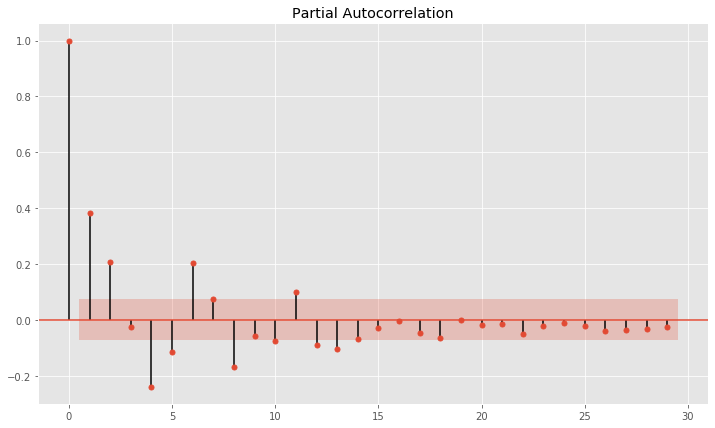

In [10]:
# Import statsmodels packages to plot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(reg_train.diff().dropna())
plt.show()

To choose our $p$ parameter, we want to find the largest lag value at which we still have significance. In this case, that is the last point at which we do not cross the significance threshold (red region). From the above graph which starts at lag 0 (which we ignore since it'll obviously be correlated to itself) and we see lag 1 and 2 are above the threshold. So we choose $p=2$. 

Similarly for $q$, we'll look at the ACF and use the same process:

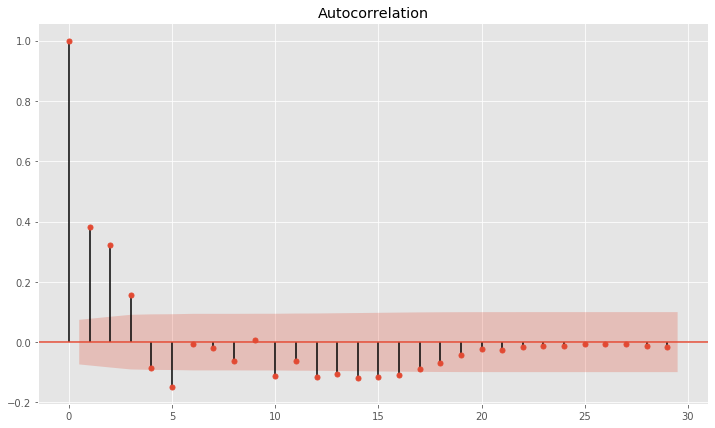

In [11]:
# Plot the acf 
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(reg_train.diff().dropna())
plt.show()

Here we see lag 3 is the last above the threshold, although given how close it is to the blue region, we could equally choose lag 2. But we shall be fairly liberal and stick to $q=3$.

Now we have all our parameters, we can fit the ARIMA model.

## 2.3. A naïve attempt to fit the model

After preselecting our values, we can now employ an ARIMA(2,1,3) model. Given the aforementioned issues about stationarity, or lack thereof, we can go into this model with little expectation of a good fit; a slightly anti-climatic affair I know. Yet this is just a first fit to conceptualise the process and we can adapt and modify our preprocessing in due time. We can first fit our model and get some information.

In [12]:
# Import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# To stop an error about frequency 
reg_train.index.freq = reg_train.index.inferred_freq

# Fit data
model = ARIMA(reg_train, order=(2,1,3))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ALL_INF   No. Observations:                  704
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -4303.199
Date:                Sun, 02 May 2021   AIC                           8618.397
Time:                        18:46:50   BIC                           8645.730
Sample:                    12-27-2004   HQIC                          8628.961
                         - 06-18-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2099      0.079      2.661      0.008       0.055       0.364
ar.L2         -0.2692      0.048     -5.566      0.000      -0.364      -0.174
ma.L1          0.0681      0.079      0.866      0.386      -0.086       0.222
ma.L2          0.6704      0.031     21.375      0.000       0.609       0.732
ma.L3          0.3102      0.033      9.497      0.000       0.246       0.374
sigma2      1.212e+04    151.178     80.192      0.000    1.18e+04    1.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52294.79
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              46.94   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From this summary, there are a few important values we want to point out. Firstly, we have the **AIC** and **BIC** score to quantify how good our model fit the training data by calculating a prediction error. This will be useful for comparisons to other models. At the bottom, we have some statistical information such as the third and fourth moment (skew and kurtosis), together alongside some other jargon which could be investigated further under certain situations. The last interest for us is the middle section, which lets us know our coefficients to our model. the **$P>|z|$** let's us know how significant these values are, and will reject any with values higher than $0.05$. Whilst the last two columns yields confidence interval for our values with an upper and lower limit. With all this we can mathematically define our model as:

$$ y_{t}= \mu + 0.21 y_{t-1} - 0.27 y_{t-2} + 0.67 \epsilon_{t-2} + 0.31 \epsilon_{t-3} $$

To predict future time steps, and compare with our testing data, we do what is called 'out-of-sample forecasting'. Then we would be able to see if our training data could paint a picture of what new, unseen, data points could be. We can use either the `predict()` or `forecast()` function, and in our case the latter is most intuitive to use given we know how far ahead in the future we want to go.  

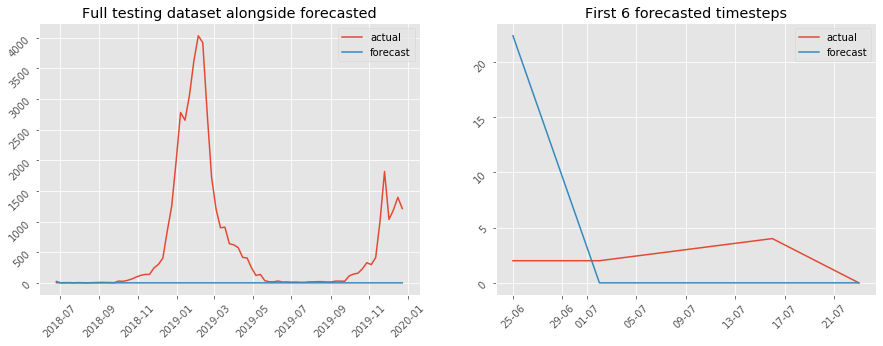

In [13]:
# Forecast the amount of points in the testing set
forecast_arima = model_fit.forecast(steps=len(reg_test))

# Set all values less than 0 to 0, which is just good practice (we can't have negative flu cases)
forecast_arima[forecast_arima<0]=0

# Define some subplots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

# Plot full testing dataset
ax1.plot(reg_test,label='actual')
ax1.plot(forecast_arima,label='forecast')
ax1.set_title('Full testing dataset alongside forecasted')
ax1.tick_params(labelrotation=45)
ax1.legend()

# Plot a zoomed in version of the first few steps 
ax2.plot(reg_test[:5],label='actual')
ax2.plot(forecast_arima[:5],label='forecast')
ax2.set_title('First 6 forecasted timesteps')
ax2.tick_params(labelrotation=45)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m')) # Just show day and month in this plot
ax2.legend()


plt.show()

Well, as it should be fairly clear, this model is useless to put it mildly. Although we have captured some of the weeks with no flu cases, this is a small victory in a sea of defeats. We can, for consistency and comparison, calculate the mean squared error, giving us a metric for how badly the model did.

In [14]:
# Import MSE package, we could do this with a simple python function but this is just a bit less clunky
from sklearn.metrics import mean_squared_error

# Mean squared error
print('Mean squared error of vanilla ARIMA model: {:.2f}'.format(mean_squared_error(reg_test, forecast_arima)))

Mean squared error of vanilla ARIMA model: 1285713.83


Hopefully we can reduce this a lot. We can reiterate again the problem with lack of stationarity, which is the main fix we need to make so that the model is viable. ARIMA can deal with some trend and seasonality, which is why we differentiate the model, but it can quickly become redundant if that does not work. Instead, we need to look a bit further to deal with reducing seasonality.

One way is to incorporate it into the model and factor some new parameters to deal with the issue, this is known as the S(easonal)ARIMA model. But it will be quite cumbersome and time consuming to reenter the theory and find these parameters; although if done again, could have been used from the start. Instead, if we were to persist with the ARIMA model, we need to do a lot more cleaning to achieve a stationary dataset and remove the pesky underlying issues with the raw dataset. 

Before we move on to our ultimate preprocessing tool, methods from scratch we can implement to make a time series more stationary include:

* Detrending: A simple but effective method to detrend data is by differences. This involves calculating the difference between the current and previous time lag, and using that as the new data point. This will also smooth out a dataset. But is also fairly limited by its simplicity

* Removing seasonality: This can be done by calculating a polynomial curve that best models a dataset and follow a similar differencing method, but in this case we subtract the curves value from the time step. 

However, a more comprehensive - and conveniently built into statsmodels - method is to utilise what we did in the visualisation section, and see if STL decomposition can help us make better predictions.

## 2.4. Better fitting the model using STL decomposition

If we think about the problems we want to address with the dataset, STL decomposition feels like a suitable tool. By combining just trend and residual error, we have some data without seasonality we can work on, and easily add seasonality back in when making our predictions later on. In addition, detrending by differencing should work a lot better with this new data and hopefully gives us more stationarity in our dataset. 

To use this to forecast time series, we fit our desired model (ARIMA) to the trend+residual components. We can use the `STLForecast()` function to do all this for us. To re-seasonalise the data, the function will use the seasonalisation from the previous "seasonal period" or an average of previous periods, so we will likely end up with a prediction that follows a similar shape to the end of our training data. 

We can first fit our ARIMA model on this decomposed time series, using the same $ARIMA(2,1,3)$ model as so:

In [15]:
from statsmodels.tsa.forecasting.stl import STLForecast

# Fit the detrended on ARIMA, there are some extra parameters we can set but the model seems to assume the best values as default
stlf = STLForecast(reg_train, ARIMA, model_kwargs=dict(order=(2,1,3), trend="t"), seasonal=7)

# Fit the model and print a nice summary
stlf_res = stlf.fit()
stlf_res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                    STL Decomposition and SARIMAX Results                     
==============================================================================
Dep. Variable:                      y   No. Observations:                  704
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -4037.348
Date:                Sun, 02 May 2021   AIC                           8088.696
Time:                        18:47:07   BIC                           8120.584
Sample:                    12-27-2004   HQIC                          8101.020
                         - 06-18-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4174      4.646      0.305      0.760      -7.689      10.524
ar.L1          0.5880      0.102      5.789      0.000       0.389       0.787
ar.L2         -0.5124      0.047    -11.008      0.000      -0.604      -0.421
ma.L1         -0.3617      0.102     -3.560      0.000      -0.561      -0.163
ma.L2          0.7137      0.033     21.698      0.000       0.649       0.778
ma.L3          0.0564      0.036      1.562      0.118      -0.014       0.127
sigma2      5695.1611    112.672     50.546      0.000    5474.328    5915.994
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12805.56
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              15.20   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.90
                                STL Configuration                                
=================================================================================
Period:                            52       Trend Length:                     101
Seasonal:                           7       Trend deg:                          1
Seasonal deg:                       1       Trend jump:                         1
Seasonal jump:                      1       Low pass:                          53
Robust:                         False       Low pass deg:                       1
---------------------------------------------------------------------------------

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

With this, we see the AIC score is less than what it was in our original ARIMA model. Which is a good start and indicates our model managed to fit the training data pretty well. Also you can see some configurations at the bottom, here it decides we have a period of 52 (so our data follows a yearly pattern) and trends in data last 2 years. We also still have the coefficients we got in our previous model and can thusly update our equation as so:

$$y_{t}=0.59 y_{t-1}-0.51 y_{t-2} - 0.36 \epsilon_{t-1} + 0.71 \epsilon_{t-2}$$

Finally let's see how it stacks up to our testing data by forecasting the last 10% of our data.

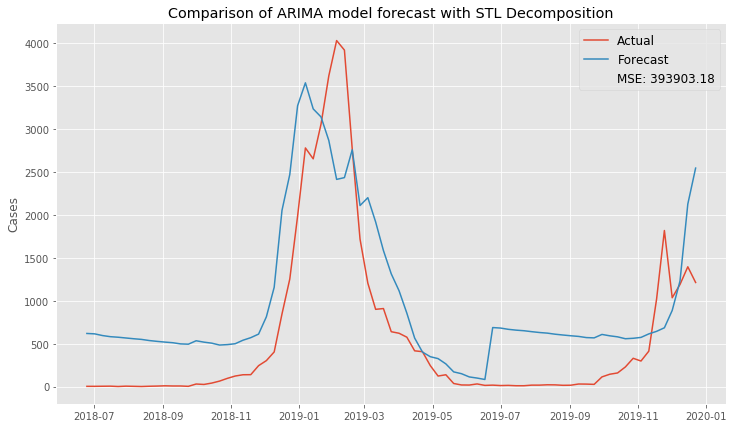

In [16]:
# Plot predictions and actual forecast
forecast_STL = stlf_res.forecast(len(reg_test))
forecast_STL[forecast_STL<0]=0
plt.plot(reg_test, label='Actual')
plt.plot(forecast_STL, label='Forecast')

# Little workaround to get MSE in same textbox as legend
plt.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(reg_test, forecast_STL)))

# Some plot styles
plt.ylabel('Cases')
plt.title('Comparison of ARIMA model forecast with STL Decomposition')

plt.legend(fontsize=12)
plt.show()

We can see this is an entire magnitude better performance than the original ARIMA model, and visually we can see it is likely even better, with a much better fit for the most part. The model does not quite predict low cases, but is good at picking up the peaks and rises with the next flu season. Given the difficulty invoking some sort of stationarity, we can treat this as a pretty big victory and can always fine tune parameters in future models.

## 2.5. Suitability

Now we have settled on our regression and prediction for this section, we can evaluate the suitability of using regression and in particular, the ARIMA model. 

As defined in section 2, our goal is to use the first 90% our our data (from end of 2004 till mid 2018) and model an outcome as to what we think the next 18 months would look like in regards to flu cases. This problem set up is perfectly suited for a regression model as we are hoping to find a relationship between the time in the year and the number of cases, and also how future time steps can be determined using past information. However, with time series we have a fairly special case of regression and needed to fit suitable models, in which we eventually settled on the popular ARIMA model. Furthering this with the STL decomposition, we have successfully achieved our goal in making a decent (albeit not perfect) forecast. 

As a little aside, if we was to take this data further, and predict future flu seasons, we would hit a slight snag, as STL Forecasting will only model for a set period, afterwards it will just replicate the same pattern. To see clearer what we mean, you can see below if we took the data for another 3 years.

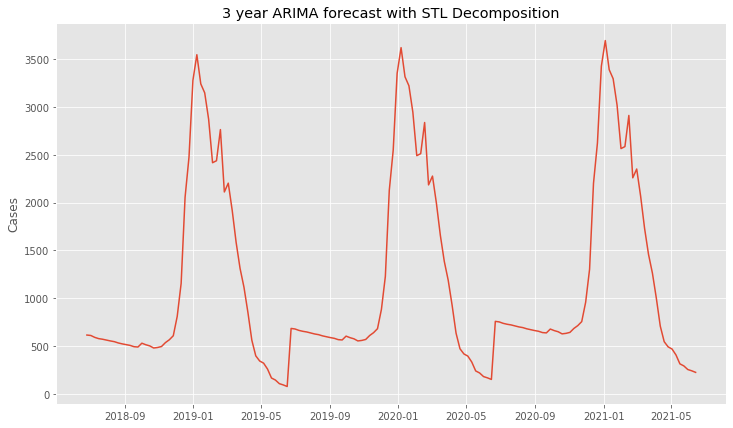

In [17]:
# Plot STL for 3 years afterwards
forecast_STL_three_years=stlf_res.forecast(52*3)
forecast_STL_three_years[forecast_STL_three_years<0]=0
plt.title('3 year ARIMA forecast with STL Decomposition')
plt.ylabel('Cases')
plt.plot(forecast_STL_three_years)
plt.show()

Although this isn't to say every method we choose would lead to this kind of outcome.

Overall this has been shown to be a suitable and useful regression technique to achieve our outcomes. With the combination of a strong preprocessing tool to make our data stationary, and a staple time series regression model. We can see how it holds up compared to other methods in the final section.

# Section 3: Machine Learning (Neural Network)

In this section we shall explore how we could model time series using a machine learning technique. With time series, to apply a modern machine learning technique we need to rethink our data and our input/output variables.

## 3.1 Neural Networks for Time Series

Neural Networks are one of the most versatile techniques in machine learning. It encompasses a plethora of different models for all different scenarios; centralising on a theme around how the brain works when processing data. Although from a statistical, and computer science, point of view, they are simply resource heavy, nonlinear statistical models. We are likely not too interested in the background and conceptualisation of what a Neural Network is, but rather the mathematics that make it up, and how each step is used to produce a desired outcome. So we can split up and talk about the different components of a neural network that matter to us:


### Weights
These are unknown parameters, attached to the edges leading into the neurons. With dense networks (all nodes in one layer connect up to all the nodes in the next layer) there can be a lot of weights to deal with, often making Neural Networks slow to train in comparison to the traditional regression models. Initially choosing these weights is also a conundrum, with different schools of thought such as initialising them as 0, or creating randomly distributed numbers close to 0. 

### Optimiser
To update and find optimal values for these weights we can use an optimiser to perform some sort of gradient descent to minimise the error, calculated as the sum of squared errors ($R(\theta)$) for regression problems. Since this is a non-convex function, issues arise in actually finding the true minimum value; therefore some quite complex algorithms are used to find these (we can discuss choosing such algorithm later). Another problem to avoid is fully minimising $R(\theta)$, as this could lead to overfitting on our training data. To accommodate for this, we can use early stopping, which will halt the training of the neural network when we see the minimisation is harming the network. To know if this is the case, we have a loss function that will tell us the error encountered during an iteration (epoch) of training. This can be coupled alongside a similar loss function for our testing set, and a clear rise in the loss of either of these (or a growing gap between the to functions) will let us know if overfitting has become a problem.

### Activation
After a weight has been applied to our values, it enters the node in which we can apply an activation function to map our values onto a non-linear function. This is more useful in classification problems, where we can fit the data to a function and allow us to attribute certain ranges to certain outcomes. However, it is still utilised in regression to scale our outputs and avoid wild, disoriented outcomes.

<hr />
With that hopefully clearing up what's going on under the hood, we next need to think about adapting our time series to fit a model such as this. When training our Network on time series data, we need to split our dataset so we can feed it $n$ input and $m$ output time steps to train on. To split our dataset we can take the first $n$ time steps (these will be our lagged values) and the next $m$ values after this will be our output, or predicted time steps. For the next batch we can just shift the data points we are taking along by one, so then we use the $2^{nd}$ to $n+1$ values as our lags, and the $m$ values after that as our predictions. This can be replicated till we have a set of input values and output values. The code to implement this can be seen a bit later and is fairly straightforward. 

For simplicity, we can just train the time series on a simple network, akin to what have been described above. This is in the form of Multilayer perceptron (MLP) Neural Network. Other networks that could be used in time series include a Recurrent Neural Network. A special case of this are LSTM models, being particularly popular for Natural Language Processing, but more recently employed on time series problems.

n.b. most of the theory for this section is taken from Hastie, [Tibshirani and Friedman (2009)](#References).

## 3.2 Preparing Data

Unlike the last section, in which we fitted a plain model without much data cleaning, this time we shall jump straight into utilising STL decomposition to invoke stationarity. Note that, last time the `STLForecast()` function re-added the seasonality to our time series data after making model predictions; this is a luxury we do not have, rather we need to add back on a seasonal component. Given we technically do not know what the season will look like in our testing set, the best guess is to try emulate what `STLForecast()` did. From the [source code](https://www.statsmodels.org/stable/_modules/statsmodels/tsa/forecasting/stl.html#STLForecast), it appears that they just add the seasonality from the previous 52 week period back onto the new predictions. We shall do the same.

Below is some general code tidbits to prepare our data for the Neural Network:

In [18]:
## STATIONARITY ##

# Assign new variables so we dont accidenlty overwrite
nn_train=data_train.copy()
nn_test=data_test.copy()

## Remove seasonal portion from data, use same params as prev. ##
stl_nn = STL(nn_train, seasonal=7)
stl_decom_nn = stl_nn.fit()

# Add residual and trend, save Seasonality to re-sample from later
nn_train_decom=stl_decom_nn.trend+stl_decom_nn.resid
seasonlity=stl_decom_nn.seasonal

Next we need to split the training data into input time steps (the lags) and output time steps (the forecast). Since at the moment we do not really know what amount of input/output neurons we want to try, we can just a generic function to split the data at our own discretion.

In [19]:
## SPLIT DATA FUNCTION ##
def split_data(input_neurons,output_neurons,data):
    # Use lists as opposed to numpy arrays for now
    # (can't expand numpy arrays and its just hassle to estimate the length)
    x,y=[],[]
    # Iterate through the dataset
    for i in range(len(data)):
        # find end of current X and y vector
        x_end=input_neurons+i
        y_end=x_end+output_neurons
        
        # If we are at the end of the series break
        if y_end>len(data):
            break
        
        # Append lists
        x.append(data.iloc[i:x_end])
        y.append(data.iloc[x_end:y_end])
    # Return as numpy arrays, easier to work with keras in this format
    return np.array(x),np.array(y)

## 3.3 Training a MLP

A Multilayer Perceptron (MLP) is fairly straightforward to code in python. With the [Keras](https://keras.io/api/) package, we can use the Sequential class to easily create layers for our Neural Network, and therefore this will form the simple model we are after. We have some decisions to make in regards to optimizer, loss and activation function. 

### Optimizer and Loss
These two are fairly straightforward to pick. For an optimizer, The Adam algorithm by [Kingma and Ba (2014)](#References) seems to be the go to choice for Deep learning tasks at the moment. Whilst using Mean Square Error as a loss functions is the standard choice.

### Activation
For an activation function we have a bit more of a dilemma, with a lot of choice provided by Keras, and not to mention the plethora of ones that we can custom implement. Initially we can use the Rectified Linear Unit (ReLu) which is a simple, popular, and powerful activation function. We can succinctly define this as:
$$ f(x)=x^{+}=max(0,x)$$
Essentially we have a straight $f(x)=x$ line for any positive value, and 0 otherwise.

The next thing to choose is the number of input and output neurons in our Network. For a start, we shall be (rather) naïve and simply give the MLP 6 input neurons, and let it spit out its predictions for the entire testing dataset, so 79 output neurons. 3 input lags may have sufficed, as this is what the ARIMA model used. However, given we have not applied differencing on our dataset this time, we wouldn't be able to use the same process in deciding the lags.

We can always adjust these parameters if we find that our model does not fit too well. For the layer number and neuron size, we shall stay fairly simple and add 2 hidden layers of 50 all connected ('dense' in the context of Keras) neurons. Again this can be modified later on.

In [20]:
# Import Keras Packages
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


# choose a number of time steps and split the dataset (we shall do 6 inputs and )
input_neurons, output_neurons = 6, len(nn_test)
lags, forecast = split_data(input_neurons, output_neurons,nn_train_decom)

# define model
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=input_neurons))
model.add(Dense(50, activation='relu'))
model.add(Dense(output_neurons))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Early stopping will halt the process when it finds the performance gets worse after a certain run through (epoch)
es = EarlyStopping(monitor='loss',verbose=1)
# Give a super high epoch number, the early stopping will likely halt before this number
history=model.fit(lags, forecast, epochs=1000, verbose=0, callbacks=[es])

Epoch 00028: early stopping


As you can see the network decided that an Epoch, well below the maximum we gave it, was where the data performed the best. We could have added a tolerance to this, and let the model continue further until we saw persistent decline in the models performance, but for now let's have a look at how well it did, by looking further into our loss during training

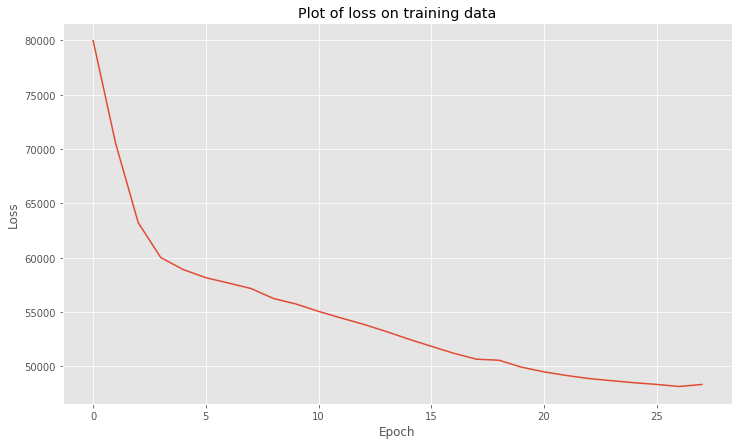

In [21]:
# Plot the loss during training
plt.plot(history.history['loss'])
plt.title('Plot of loss on training data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

These loss numbers are certainly high (attributed to the large numbers we are working with in the dataset), but we see a clear downward trend which is a positive. Now let's make some predictions!

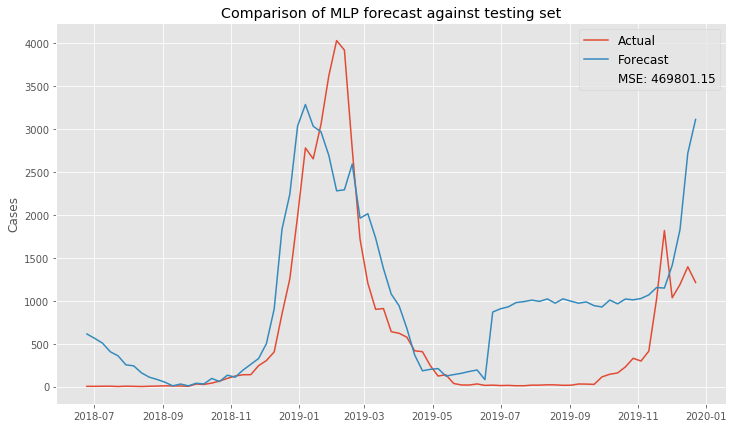

In [22]:
# Make some predictions by taking the last 6 values in the training set and try forecast the entire testing set
x_input=np.array(nn_train_decom[-6:])
x_input = x_input.reshape((1, 6))
pred = model.predict(x_input, verbose=0)

# Readd the seasonality component, this code is kinda fudged together
a=(pred[0][:52]+seasonlity[-52:].values)
b=(pred[0][52:]+seasonlity[-52:(-52+(len(nn_test)-52))].values)
pred_MLP=np.concatenate((a,b))

# Remove all values below 0, set them to 0 (good practice we used in prev. section)
pred_MLP[pred_MLP<0]=0

# Plot the NN-forecast against the original testing dataset
plt.plot(nn_test, label='Actual')
plt.plot(nn_test.index[:len(nn_test)],pred_MLP,label='Forecast')
# Little workaround to get MSE in same textbox as legend
plt.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(nn_test, pred_MLP)))

# Some plot styles
plt.ylabel('Cases')
plt.title('Comparison of MLP forecast against testing set')

plt.legend(fontsize=12)
plt.show()

Not looking too bad! We've managed to fit a rough peak to our actual flu cases, and manages to follow the winter period reasonably well, akin to the ARIMA model. However, afterwards we see this performance dips greatly. This could indicate we have too many output neurons (we did add 79). Or the network just isn't built to look that far into the future, and heavily influenced by the seasonal component discussed at the end of the last section.

We can now adapt our network and do some quick experimenting to see if we can get some better results.

## 3.4 Improving our Neural Network Model

We can now begin to tweak and experiment with different hyper parameters. There's a number of changes we can make, and we can experiment in different areas of the model.

### Modification 1: Different input/output neurons
With this change, instead of forecasting the entire testing dataset, we shall output 10 future time steps then put these new points back into the network and predict again, until we have a forecast for the entire period. To make our lives easier we shall also input 10 time steps into the network. A problem we might face would be if 10 neurons is enough to capture a downward or upward trend; if not then the MLP could quickly get out of hand, we can see if this is the case below. 

In [23]:
# Train model on 10 inputs/10 outputs #

# Split dataset
lags, forecast = split_data(10, 10,nn_train_decom)

# Fit model (same way as prev.)
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=10))
model.add(Dense(50, activation='relu'))
model.add(Dense(10))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Early stopping will halt the process when it finds the performance gets worse after a certain run through (epoch)
es = EarlyStopping(monitor='loss',verbose=1)

# Give a super high epoch number, the early stopping will likely halt before this number
history=model.fit(lags, forecast, epochs=1000, verbose=0, callbacks=[es])

Epoch 00009: early stopping


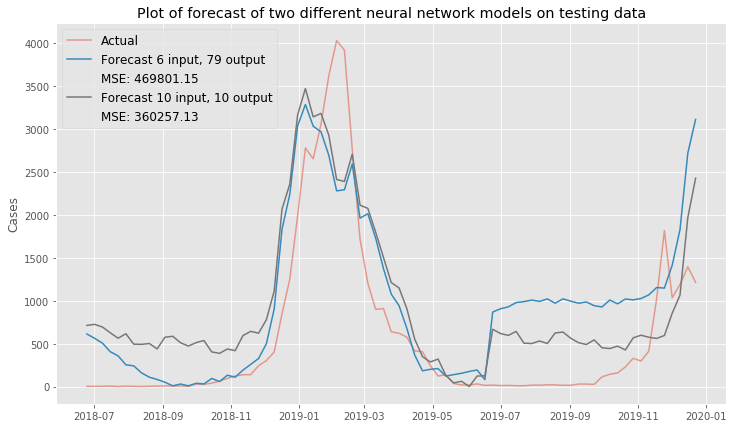

In [24]:
# Generate iterative predictions, first get the last 10 points of the training set and create a blank list to check
ten_ten_forecast=[]
ten_ten_inputs=np.array(nn_train_decom[-10:])
ten_ten_inputs=ten_ten_inputs.reshape((1, 10))

# Length of testing is 79, so iterate 8 times to generate a forecast of 80 points, and cut off the last
for i in range(0,8):
    ten_ten_forecast.append(model.predict(ten_ten_inputs, verbose=0))
    ten_ten_inputs=ten_ten_forecast[i]
    ten_ten_inputs.reshape((1,10))
    
# Flatten the array to just get a 1-d array of single values, plus cut off the last value
ten_ten_forecast=np.array(ten_ten_forecast[:]).flatten()[:-1]

# Re-add seasonality the same hacky way as before
a=(ten_ten_forecast[:52]+seasonlity[-52:].values)
b=(ten_ten_forecast[52:]+seasonlity[-52:(-52+(len(nn_test)-52))].values)
ten_ten_pred=np.concatenate((a,b))

# Set all negative values to 0
ten_ten_pred[ten_ten_pred<0]=0

# Plot the predicitons compared to the old way and actual
plt.plot(nn_test,alpha=0.5, label='Actual') # Make it a bit feint to add emphasis on the other lines
plt.plot(nn_test.index[:len(nn_test)],pred_MLP,label='Forecast 6 input, 79 output')
plt.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(nn_test, pred_MLP)))
plt.plot(nn_test.index[:len(nn_test)],ten_ten_pred,label='Forecast 10 input, 10 output')
plt.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(nn_test, ten_ten_pred)))
plt.ylabel('Cases')
plt.title('Plot of forecast of two different neural network models on testing data')
plt.legend(fontsize=12)
plt.show()

It appears that the 10 input/10 output model worked kinda ok and similar to the original Neural Network model, especially with the main peak. The main difference between the two being the more prolonged period of low cases before a rise again after the first peak. 

Another modification we can try is through seasonal periods, i.e. 52 inputs and 52 outputs to predict each yearly period.

In [25]:
# Train model on 52 inputs/52 outputs #

# Split dataset
lags, forecast = split_data(52, 52,nn_train_decom)

# Fit model (same way as prev.)
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=52))
model.add(Dense(50, activation='relu'))
model.add(Dense(52))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Early stopping will halt the process when it finds the performance gets worse after a certain run through (epoch)
es = EarlyStopping(monitor='loss',verbose=1)

# Give a super high epoch number, the early stopping will likely halt before this number
history=model.fit(lags, forecast, epochs=1000, verbose=0, callbacks=[es])

Epoch 00083: early stopping


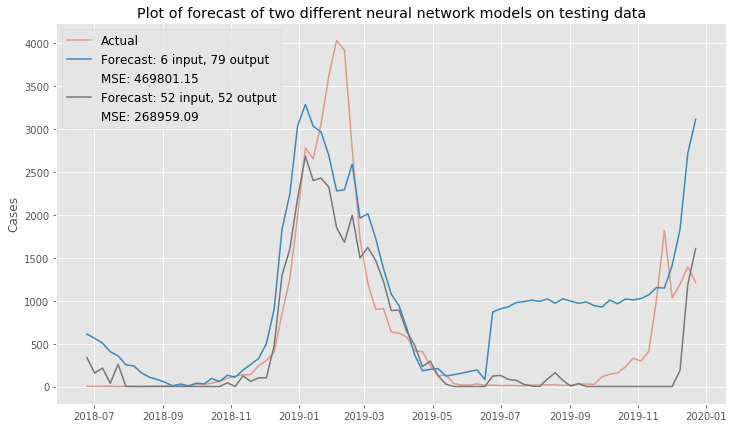

In [26]:
# Generate iterative predictions, first get the last 10 points of the training set and create a blank list to check
nn_season_forecast=[]
nn_season_inputs=np.array(nn_train_decom[-52:])
nn_season_inputs=nn_season_inputs.reshape((1, 52))

# Length of testing is 79, so iterate 2 times to generate a forecast of 104 points, and cut off the last so many
for i in range(0,2):
    nn_season_forecast.append(model.predict(nn_season_inputs, verbose=0))
    nn_season_inputs=nn_season_forecast[i]
    nn_season_inputs.reshape((1,52))
    
# Flatten the array to just get a 1-d array of single values, plus cut off the last value
nn_season_forecast=np.array(nn_season_forecast[:]).flatten()[:-25]

# Re-add seasonality the same hacky way as before
a=(nn_season_forecast[:52]+seasonlity[-52:].values)
b=(nn_season_forecast[52:]+seasonlity[-52:(-52+(len(nn_test)-52))].values)
nn_season_pred=np.concatenate((a,b))

# Set all negative values to 0
nn_season_pred[nn_season_pred<0]=0

# Plot the predicitons compared to the 10/10 way
plt.plot(nn_test,alpha=0.5, label='Actual') # Make it a bit feint to add emphasis on the other lines
plt.plot(nn_test.index[:len(nn_test)],pred_MLP,label='Forecast: 6 input, 79 output')
plt.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(nn_test, pred_MLP)))
plt.plot(nn_test.index[:len(nn_test)],nn_season_pred,label='Forecast: 52 input, 52 output')
plt.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(nn_test, nn_season_pred)))
plt.ylabel('Cases')
plt.title('Plot of forecast of two different neural network models on testing data')
plt.legend(fontsize=12)

plt.show()


This one worked out similar again to the 6 input/79 output model, but with a slightly smaller peak, and longer period of no cases. We can also note that due to the similarity in MSE scores, coupled with the stochastic nature of neural networks, it will be pretty difficult to definitively say which of these changes is best. Depending on when we run the models, some cases it may have one significantly better than the other. With this in mind moving into the next modification, we can be fairly relaxed that whatever we choose as the input/output choice, we will not significantly miss out or hinder the model too much.

### Modification 2: Different Activation Functions

For the above tests, we have been using the ReLU activation function, but Keras has many more it can use. Therefore, below we see if changing these activation functions can significantly improve (or worsen) our predictions. We will experiment with 3 other popular activation functions these are:

* Sigmoid:
    $$f(x)=\frac{1}{1+e^{-x}}$$
* ELU: The Exponential Linear Unit 
    $$ELU(x)=\begin{cases} x, &\textrm{if} \ x>0 \\ \alpha (e^{x}-1), \ &\textrm{if} \ x<0\end{cases}$$
  the default $\alpha$ value for keras is 1.
* Tanh: the hyperbolic tangent function


Also, for consistency, each model will have the same 2-50 neuron hidden layers and 6 input/79 output neurons. And utilise the Adam algorithm for optimisation.

Testing Activation: sigmoid
Epoch 00202: early stopping


Testing Activation: elu
Epoch 00025: early stopping


Testing Activation: tanh
Epoch 00121: early stopping




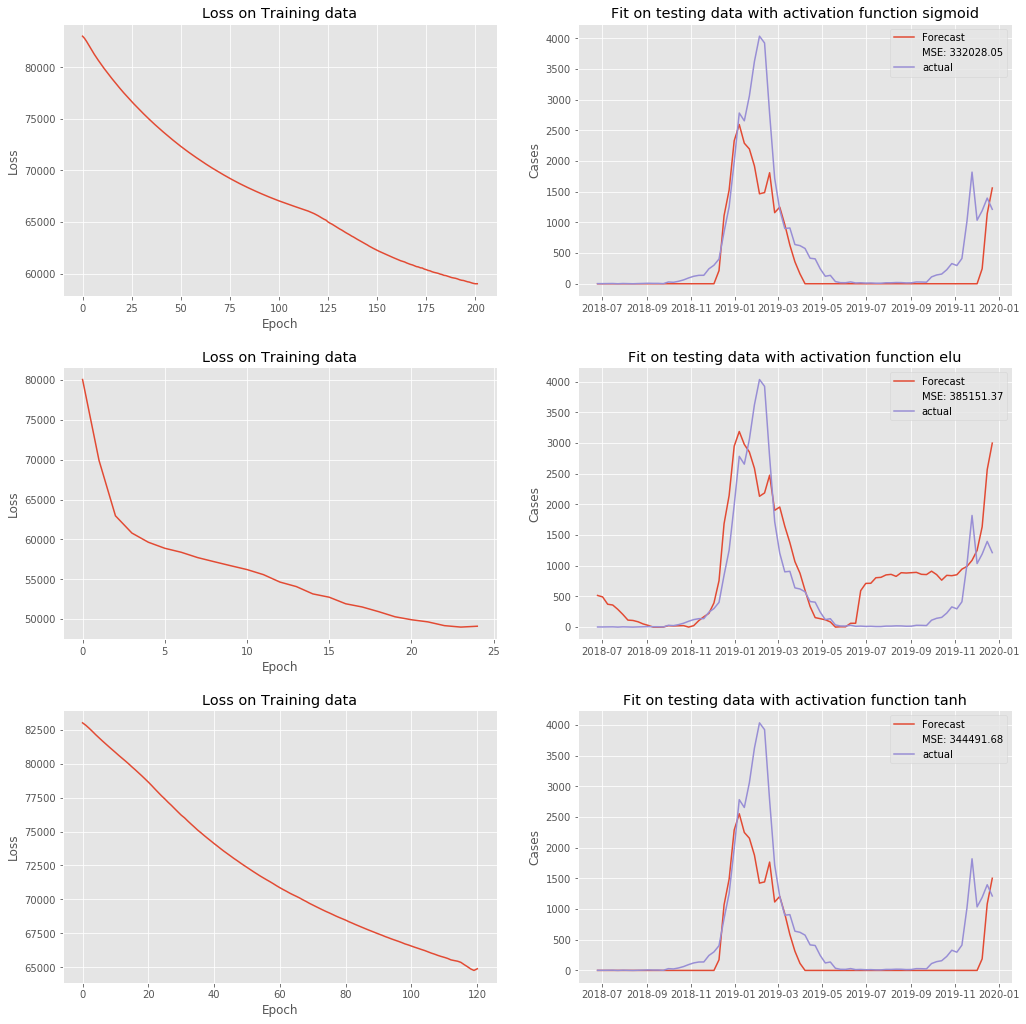

In [27]:
# Code to test activation functions
# For each one plot loss on training data, forecast, and MSE

# Create subplots, for each activation function, we'll plot the training loss and the fit vs. Actual
# There are 3 plots we are using so a 3x2 grid of subplots is required
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(15,15))

fig.tight_layout(pad=5.0) # Add some spacing between subplots, does make things blurry for some reason 
                    
# Keep tabs of activatation functions
activations=['sigmoid','elu','tanh']

# Split dataset
lags, forecast = split_data(6, len(nn_test),nn_train_decom)

# iterate through each  activation function
for idx, activation in enumerate(activations):
    print('Testing Activation: ' + activation)
    # Fit model (same way as prev.)
    model = Sequential()
    model.add(Dense(50, activation=activation, input_dim=6))
    model.add(Dense(50, activation=activation))
    model.add(Dense(len(nn_test)))
    
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    # Early stopping will halt the process when it finds the performance gets worse after a certain run through (epoch)
    es = EarlyStopping(monitor='loss',verbose=1)
    # Give a super high epoch number, the early stopping will likely halt before this number
    history=model.fit(lags, forecast, epochs=1000, verbose=0, callbacks=[es])
    
    # Make some predictions by taking the last 6 values in the training set and try forecast the entire testing set
    x_input=np.array(nn_train_decom[-6:])
    x_input = x_input.reshape((1, 6))
    pred = model(x_input)
    
    # Readd the seasonality component, this code is kinda fudged together
    a=(pred[0][:52]+seasonlity[-52:].values)
    b=(pred[0][52:]+seasonlity[-52:(-52+(len(nn_test)-52))].values)
    pred=np.concatenate((a,b))

    # Remove all values below 0, set them to 0 (good practice we used in prev. section)
    pred[pred<0]=0

    # Plot the NN-forecast against the original testing dataset
    ax[idx,0].plot(history.history['loss'])
    ax[idx,0].title.set_text('Loss on Training data')
    ax[idx,0].set_xlabel('Epoch')
    ax[idx,0].set_ylabel('Loss')
    ax[idx,1].plot(nn_test.index[:len(nn_test)],pred,label='Forecast')
    ax[idx,1].plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(nn_test, pred)))
    ax[idx,1].plot(nn_test,label='actual')
    ax[idx,1].title.set_text('Fit on testing data with activation function ' + activation)
    ax[idx,1].set_ylabel('Cases')
    ax[idx,1].legend()
    print('\n')
plt.show()
    

From this we see the elu produces similar results to the original ReLu function. In tanh and sigmoid, we see worse performance on the training data, and loss curves which appear more of a linear downward trend. This is alongside some woeful estimations of the main peak in the testing data. However, through the quirk of setting negative values to 0, we do pick up a lot of the low case numbers and, on a  technicality, more chance of attaining a lower MSE; but we cannot say these are better performing than elu or even ReLU. This highlights an importance in not just relying on the statistical information, but also looking visually and interrogating the data.

### Modification 3: Layers, neurons size and stopping condition changes

The final modification we can explore is the changes to the number of layers, and neurons packed into these layers, with some more tolerance on the stopping condition. In our initial choosing, we was not very scientific or rigorous in the reasoning behind picking two 50 neuron hidden layers. To address this we can look into theories on how to best pick these, starting with research by [Kůrková (1992)](#References) which highlighted the usefulness of a two hidden layer network. So persisting with this for now, it leads a more tricky decision to contemplate the number of neurons in these layers. [Huang et al. (2003)](#References) suggests the following choices for a 2 layer hidden network:
* Layer 1: $\sqrt{(m+2)N}+2\sqrt{N/(m+2)}$
* Layer 2: $m\sqrt{N/(m+2)}$

Where $N$ is the number of training samples  and $m$ is the size of the output layer. 

This study was expanded upon by [Stathakis (2009)](#References), who discussed the lack of a paradigm that could give near-optimal outcomes. They found that the best way to calculate the number of hidden neurons needed is through a method of pruning and incrementally adding (or removing) neurons during iterations; with the Kanellopoulos–
Wilkinson rule coming out best. We shall avoid implementing this here as it is likely beyond the scope of the project. Instead we can use [Huang et al. (2003)](#References) ruling and by subbing in our $N=704$ and $m=79$ we attain the following layer sizes:

* Layer 1: 245
* Layer 2: 234

These are fairly big numbers, attributed to our large number of training samples. 

Before implementing our modification set, we can also tinker with the stopping condition. Currently we have early stopping when the network encounters loss higher than the previous epoch. We can add some patience to this, meaning we won't stop the training immediately, rather we stop if there is consistently worse performance. For the next model we can set our patience to around 10 and see where that takes us.

Epoch 00122: early stopping


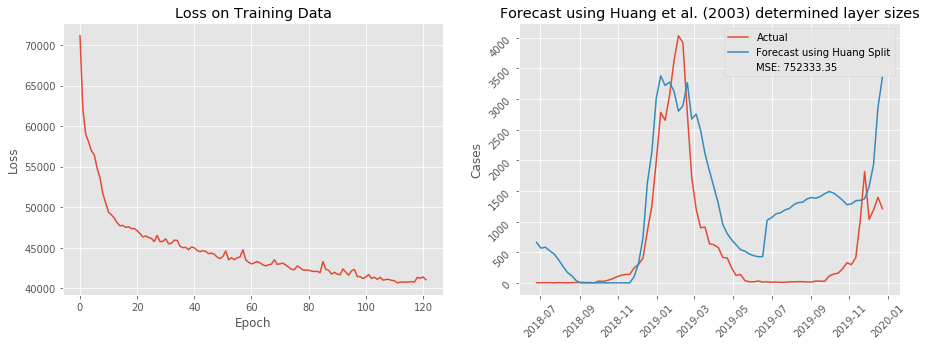

In [28]:
# choose a number of time steps and split the dataset (we shall do 6 inputs and )
input_neurons, output_neurons = 6, len(nn_test)
lags, forecast = split_data(input_neurons, output_neurons,nn_train_decom)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

# define model
model = Sequential()
model.add(Dense(245, activation='relu', input_dim=input_neurons))
model.add(Dense(234, activation='relu'))
model.add(Dense(output_neurons))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Early stopping will halt the process when it finds the performance gets worse after a certain run through (epoch)
es = EarlyStopping(monitor='loss',verbose=1,patience=10)
# Give a super high epoch number, the early stopping will likely halt before this number
history=model.fit(lags, forecast, epochs=1000, verbose=0, callbacks=[es])


# Make some predictions by taking the last 6 values in the training set and try forecast the entire testing set
x_input=np.array(nn_train_decom[-6:])
x_input = x_input.reshape((1, 6))
pred = model(x_input)

# Readd the seasonality component, this code is kinda fudged together
a=(pred[0][:52]+seasonlity[-52:].values)
b=(pred[0][52:]+seasonlity[-52:(-52+(len(nn_test)-52))].values)
pred_Huang=np.concatenate((a,b))

# Remove all values below 0, set them to 0 (good practice we used in prev. section)
pred_Huang[pred_Huang<0]=0

ax1.plot(history.history['loss'])
ax1.set_title('Loss on Training Data')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the NN-forecast against the original testing dataset
ax2.plot(nn_test, label='Actual')
ax2.plot(nn_test.index[:len(nn_test)],pred_Huang,label='Forecast using Huang Split')
ax2.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(nn_test, pred_Huang)))
ax2.set_ylabel('Cases')
ax2.tick_params(labelrotation=45) # Angle down the axes for easier reading
ax2.set_title('Forecast using Huang et al. (2003) determined layer sizes')
ax2.legend()

plt.show()

As we can see there is a clear downward, if not a bit shaky, loss trend on our training data. However the fit on the testing set is a bit worse than the others.

## 3.5 Evaluation of Neural Network models

In this section we have attempted to make forecasts with our time series using a neural network model. By converting our dataset and adapting a time series problem to one that is suitable for a neural network to work on, we have found that we produce some decent, but unpredictable, results. 

The most difficult problem faced using the model was selecting the right hyper-parameters. Neural Networks are pretty hard to fine tune, and can be computationally expensive (especially running on this early 2014 Macbook Air) so choosing the right hyper-parameters was not the easiest of tasks. This must be taking into account when evaluating the model in the context of the dataset, as there will likely exist a more optimal set up. In addition, these models are not designed around being friendly for time series, instead we had to fudge our data to accommodate this Machine Learning technique. If we had a decent extra set of data, to perhaps use as a validation set, and monitored the loss on that rather than the training set, we could have made better predictions. Albeit the method we used and parsing seemed to work pretty well.

With regards to results, choosing what produced the best outcome to our data is also quite a difficult affair. Most of the MLP models generated produced similar results, even through each type of iteration. Given this, alongside the stochastic and unpredictable nature of Neural Networks in general, depending when we last ran the models we could get different ones coming out on top. In the most recent run, it was found that the **52 input/52 output** network produces the lowest MSE score, and we shall take this into our final section as the representative from this section.

Overall, most of these models managed to accurately predict the presence of peaks in the testing set, and from the loss plots, we saw that the model did get better over iterations when training on the historical cases. Where this model failed was the anticipation of a lower second peak. Most of the models ran assumed a sharp rise after the dip,  in contrast to the reality of a much shallower rise. Another failure is the model either not dipping enough after the peak (i.e. never reaching 0 cases again) or perhaps overshooting the cases collapsing. This latter scenario is seen when we have a large flat line in the predictions, as these are just negative values we adjusted to be 0.

We can discuss next section if there is a reason for the mishaps of the models, as some of the quirks have also been seen in the ARIMA model too.

# Section 4: Evaluation

## 4.1. Summary of Findings

We can plot the best model for both techniques below and see how they fit on the same graph with respect to the actual case numbers. This was the ARIMA model with STL decomposition, and the 52 input/52 output MLP neural network.

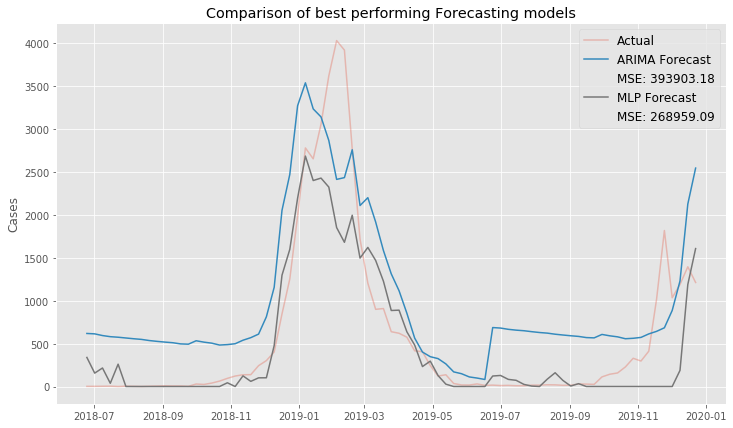

In [29]:
plt.plot(reg_test, label='Actual', alpha=0.3)
plt.plot(forecast_STL, label='ARIMA Forecast')
plt.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(reg_test, forecast_STL)))
plt.plot(nn_test.index[:len(nn_test)],nn_season_pred,label='MLP Forecast')
plt.plot([], [], ' ', label='MSE: {:.2f}'.format(mean_squared_error(nn_test, nn_season_pred)))

# Some plot styles
plt.ylabel('Cases')
plt.title('Comparison of best performing Forecasting models')

plt.legend(fontsize=12)
plt.show()

From a visual standpoint, we see that the ARIMA model captured the actual peak best, but never predicted low case numbers. Whereas the best performing MLP forecast, undersold the peak, but captured the low numbers and the realistic scenarios of 0 cases (yet this is still a slight quirk). You can also see unnatural looking lines in the ARIMA forecast during in the mid to late 2019 period. Perhaps attributed to the addition of seasonality and some peculiarity in how the `STLForecast()` model dealt with this, but it is undoubtedly detrimental to the goals of forecasting. 

We can also see the effect that STL decomposition, and more importantly the seasonal component, has on the spread of cases. We see the shapes and mould of the peaks on the two predictions, well defined and almost identical, albeit shifted, from each other. Obviously since both methods sample seasonality from the previous 52 week period, they would be similar, yet the manner of the definition in these peaks highlights the influence the seasonal component has on the cases. In the context of real life, this is fairly obvious as flu is a seasonal occurrence.

### (Brief) Statistical comparison between Neural Network and ARIMA Model

In addition to a visual and anecdotal summary, we can also statistically interrogate our findings. For both methods we calculated some statistical information on the testing sets, So it would useful to compare these for both models. 

For the testing set this is straightforward, as we calculated the same metric, Mean Squared Error, in both models. Using the best configuration for each respective method we attained:

* Testing MSE for ARIMA: 393903

* Testing MSE for MLP: 268959

Showing over the entire testing period, contained the least deviations, albeit this can clearly be skewed and penalised heavily by just a few misplaced points.

Another metric that is likely more useful for comparison is the AIC score. We define the AIC by its original definition as:
$$2k-2\ln(L)$$
For $k$ parameters and the likelihood function $L$.

Although the AIC by convention uses the log likelihood in its calculations, the mean square error could be used instead. i.e. we write the AIC as:
$$2k+n\ln(\textrm{MSE})$$
For $k$ model parameters and $n$ samples [(Burnham and Anderson 2010)](#References).

Since both methods, we calculated a MSE, this is likely the better one to use. Giving us:

* Testing AIC for ARIMA $(k=3)$: 1024

* Testing AIC for MLP ($k=7700$)\*: 15412

You can see that we have been heavily penalised for the large number of parameters used in the neural network. This is perhaps an unfair penalty as the intention is to alarm people for possible overfitting when using large quantities of parameters; yet the neural network is built on purpose with many different permutations and weights, to best capture complex systems. This maybe indicates AIC isn't as useful as a characteristic as it could be, or is better suited to more simple parametric models. 


Overall, we can see that the respective models statistical information is perhaps not best suited for direct comparisons. Instead, it could be wiser to take an approach of carefully contemplating different quantitative and qualitative properties.

\* This has been calculated as all the edges connecting the neurons in each layer, which, for the 52 input, 2 50 hidden layers, 52 output layer amounts to:
$$(52\cdot 50) + (50\cdot 50) + (50\cdot 52)= 7700$$

## 4.2. Methodology Rankings

On the topic of ranking the methods, below is a worst to best order of how well suited they where to the task at hand (see Goals Of Dataset). For each ranking, there are some bullet points exploring the rational between the positioning and merits/improvements that could be made.

### 3. Graphical Representation

#### Suitability to forecasting
* By far the weakest and least suited to forecasting, hard to to make predictions from just visually seeing the data, reliance on guesstimating trends.

* Original time series plot a little boring, but made a lot more interesting and informative with the decomposed plot. Some predictions could be made by looking at relation between trend and seasonality, and predicting where that would lead the cases. Residual plot lets us know beforehand how inaccurate we could be.


#### Suitability to the Dataset
* STL decomposed plots suited in helping us see the seasonality and trend present in data, to understand what was going on and aided us with the preprocessing steps in other models.

* When filling in missing values, graphically seeing the dataset let us know that mean/mode imputation simply would not have led to good predictions, allowing us to explore other methods and settle on interpolation.

### 2. Neural Network

This may seem a tad counterintuitive when you look purely at the mean square error metric, yet there are far more pertinent parameters to gauge the suitability of a technique.

#### Suitability to forecasting
* This was able to predict far in the future with some good levels of accuracy.

* Can be used in multiple ways and doesn't really discriminate on the number of lags or forecast values we want to find.

* Similar accuracy as the ARIMA model, but results vary with every iteration of the model. This isn't great when in realistic situation we want reliable, consistent results. 

* Difficult to select the optimal hyper-parameters without extensive testing and research, plus there is no set paradigm in choosing these. A grid search is often employed in these scenarios but take a long time to run.

#### Suitability to the Dataset
* Neural Networks are extremely versatile and can adapt to most problems, however it did take some manipulation of the data to convert into an appropriate form in addition to making the data stationary.

* Neural Networks can sometimes be overkill with simple, single feature events. Perhaps with multivariate, it would perform better than conventional time series techniques. But that doesn't mean to say it will perform well itself.

### 1. ARIMA model

#### Suitability to forecasting
* Will give the same results when using the same parameters every time. Easier to fit and is designed for forecasting.

* Many packages to implement Forecasting, highlights its usability and usefulness in real world applications. As well as being quick and running in a fraction of the time compares to a neural network.

* Didn't model the data perfectly, and failed completely without the incorporation of seasonality but these are easy to change and we did get a reliable insight and can easily infer cases when using ARIMA as and aid as opposed to outright prediction.

#### Suitability to the Dataset
* Was designed to be used for time series models, and is therefore easy to fit and takes little effort to implement. 

* Is not suited to the complexity without stationarity being invoked, there are much better time series datasets that will perform almost perfectly with ARIMA but this is rarely encountered in real world dataset, so to adapt and still produce dependable results is amicable. 

<hr />
It could be argued that the preprocessing, and eventual forecasts made, would not have been made without the use of the visualisation, so whilst it is the worst suited, it still helped us made better models with other techniques, and therefore was still a vitally useful tool.

## 4.3. Limitations

There are of course limitations when it came to this dataset and implementation of models. The initial raw dataset had many issues which made it hard to work with, as we've talked about exhaustively throughout. The most potent being the lack of stationarity in the dataset. Obviously, we accommodate for this by removing seasonality and trying to de-trend the data points, but the data we was left with was still not completely stationary. This is more of a problem with the ARIMA model which relies more heavily on stationary time points.

Another acknowledgment to consider is the computational cost of finding optimal parameters. This is more so the case in neural networks, as fine-tuning and running the network was computationally very expensive! Given the number of parameters used as well, it is phenomenally treacherous, and likely hopeless, endeavour to understand and see these values. A neural network is almost a black box in how it works, diving into the model to find where issues lie is fruitless and in contrast to the ARIMA model which is a simple linear combination of terms we can easily manually fine tune.

To solve issues with picking the perfect hyper-parameters, and even the ARIMA parameter choice, a grid search could be used to locate which combination yields the best outcomes. With ARIMA, this is known as Auto-ARIMA and has packages in languages such as R to implement.

## 4.4. Future Investigations

People have been modeling epidemics and spreading of infectious diseases such as the flu since the $17^{th}$ century. With more established methods such as SIR and stochastic models being employed to model outbreaks and cases. These take in a lot more variables, priors and just general information from biological contexts to model and forecast cases. This is something that simply cannot be replicated at the moment by a computer and some historical time series. Whilst we can also model infectious diseases as a dynamical system, and find cases using some fancy differential equations.

We could however, be incorporating a few extra factors into our computational model. This would lead to a multivariate time series, as opposed to the univariate we used in this project, and the additional extra factors could yield better predictions. Implementing this is a lot harder than what we have done, and unless we pick features we know have an impact on cases, we won't automatically have more information leading to better predictions if the information isn't good in the first place.

Some other changes we could make if we was to revisit this project, would be perhaps standardising, or normalising the data. This would involve scaling down our dataset, or making all data points have the same distribution (mean 0 and standard deviation 1). Doing so would perhaps make comparison of methodologies easier as the numbers churned out would be smaller and easier to quantify. But caution would need to be made in rescaling data back to give us our actual cases forecasting.


Finally, a list of alternative classical and machine learning techniques that could be used on this problem, include:

**'Classical' Regression:**
* Persistent Forecasting: This super simple method involves assuming the next time step is the same as the last time step. This only works for rolling forecasts in which we are only calculating one time step at a time, which we have  not done so in our case. A similar interpretation for our dataset could assume the next seasonal period, follows the last. Which is similar to how we put back our seasonality on the decomposed time series
* The Holt-Winters seasonal method: Aims, like STL Decomposition, to acknowledge seasonality in forecasting time series. One of the oldest time series methods, it can use additive or multiplicative models to decompose a time series into a position to make predictions.
* Vector Autoregression (VAR): this could be in either section and is more well suited for multiple features. From which it can then be transformed into a univariate time series ready for forecasting.

**Machine Learning**
* Long Short Term Memory (LSTM): An artificial neural network which holds back some information with each training loop, unlike the MLP which starts fresh with every training instance. You can see why this might be useful with time series and letting a network know more about what happened in the past.
* Support Vector Regression (SVR): An offshoot of the popular Support Vector Machine method for classification, adapts the concept of support vectors and transforms. Useful for higher dimensional problems with many features as SVR don't depend on dimensionality when optimising.
* Gaussian Processes (GP): Heavily doused in statistical theory, this method assumes the individual time steps are multivariate normal distributions, and then the GP can be employed as a nonparametric regression method. This was introduced and used on time series by [Roberts et al. (2013)](#References).

A comparison of these methods, along with some extra ones, was the subject of a paper by [Makridakis et al. (2018)](#References). They found that the classical methods tended to outperform the machine learning methods in most scenarios. Although they used a slightly more stationary time series in the paper.

# References

Box, G. E. P. et al. (2016) Time series analysis: forecasting and control. Fifth edition. Hoboken, New Jersey: John Wiley & Sons, Inc (Wiley series in probability and statistics).

Burnham, K. P. and Anderson, D. R. (2010) Model selection and multimodel inference: a practical information-theoretic approach. 2. ed. New York, NY: Springer.

Cleveland, R. B.; Cleveland, W. S.; McRae, J. E. & Terpenning, I. (1990), 'STL: A Seasonal-Trend Decomposition Procedure Based on Loess (with Discussion)', Journal of Official Statistics 6 , 3--73.

David A. Dickey & Wayne A. Fuller (1979) Distribution of the Estimators for Autoregressive Time Series with a Unit Root, Journal of the American Statistical Association, 74:366a, 427-431, DOI: 10.1080/01621459.1979.10482531

Hastie, T., Tibshirani, R. and Friedman, J. (2009) The Elements of Statistical Learning. New York, NY: Springer New York (Springer Series in Statistics). doi: 10.1007/978-0-387-84858-7.

Huang, J., Shimizu, H. and Shioya, S. (2003) ‘Clustering gene expression pattern and extracting relationship in gene network based on artificial neural networks’, Journal of Bioscience and Bioengineering, 96(5), pp. 421–428. doi: 10.1016/S1389-1723(03)70126-1.

Kingma, D.P. and Ba, J., 2014. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

Kůrková, V. (1992) ‘Kolmogorov’s theorem and multilayer neural networks’, Neural Networks, 5(3), pp. 501–506. doi: 10.1016/0893-6080(92)90012-8.

Makridakis S, Spiliotis E, Assimakopoulos V (2018) Statistical and Machine Learning forecasting methods: Concerns and ways forward. PLoS ONE 13(3): e0194889. https://doi.org/10.1371/journal.pone.0194889

Nettleton, D. (2020) STAT 510: Applied Time Series Analysis, Penn State University Lecture notes, Available at: https://online.stat.psu.edu/stat510/ (Accessed: 07/04/2021)

Roberts S., Osborne M., Ebden M., Reece S., Gibson N. and Aigrain S. 2013 Gaussian processes for time-series modelling Phil. Trans. R. Soc. A.3712011055020110550
http://doi.org/10.1098/rsta.2011.0550

D. Stathakis (2009) How many hidden layers and nodes?, International Journal of Remote Sensing, 30:8, 2133-2147, DOI: 10.1080/01431160802549278